In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import binom
from numpy.random import normal, binomial
from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions, stats_functions
from bootstrap import *

plt.style.use('ggplot')

__[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))__ is any test or metric that uses random sampling with replacement (e.g. mimicking the sampling process), and falls under the
broader class of resampling methods. Bootstrapping assigns measures of accuracy (bias, variance, confidence intervals, prediction error, etc.) to sample estimates. This technique allows estimation of the sampling distribution of almost any statistic using random sampling methods.

Bootstrapping estimates the properties of an estimand (such as its variance) by measuring those properties when sampling from an approximating distribution. One standard choice for an approximating distribution is the empirical distribution function of the observed data. In the case where a set of observations can be assumed to be from an independent and identically distributed population, this can be implemented by constructing a number of resamples with replacement, of the observed data set (and of equal size to the observed data set).

It may also be used for constructing hypothesis tests. It is often used as an alternative to statistical inference based on the assumption of a parametric model when that assumption is in doubt, or where parametric inference is impossible or requires complicated formulas for the calculation of standard errors.

# Experiment 1

For example, let's generate two samples of the exponential distribution with similar $\beta$ parameter

In [2]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)
data_df = pd.DataFrame({'sample_1':pd.Series(sample_1), 'sample_2':pd.Series(sample_2)})

These samples have no significant difference in descriptive statistical parameters; let's check it in the experiment

<Axes: ylabel='Count'>

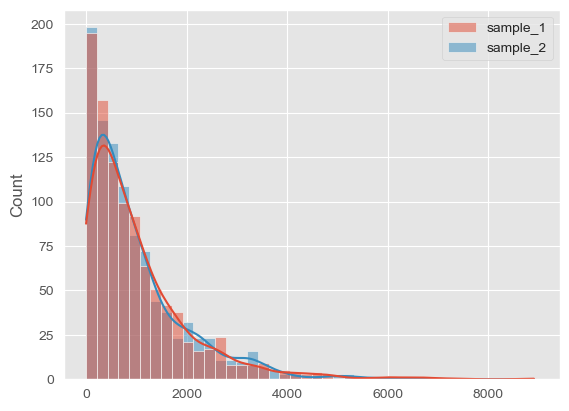

In [3]:
binwidth, bins = estimate_bin_params(sample_1)
sns.histplot(data_df, binwidth=binwidth, bins=bins, kde=True)

The essence of this experiment is to conduct several experiments in which we will take subsamples with replacements from our samples. We will calculate the mathematical expectation of the difference between the two subsamples($M[subsample_1-subsample_2]$) in every case and then build a histogram with the result of our experiments

  0%|          | 0/10000 [00:00<?, ?it/s]

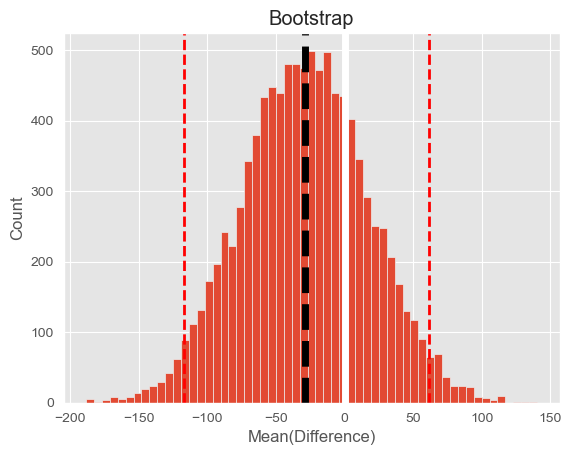

(0.5293217618315575,
 -28.825504939162776,
 [-117.33459128753867, 61.520092368643844])

In [4]:
p_value, bootstrap_difference_mean, bootstrap_confidence_interval, bootstrap_difference_distribution = bootstrap(sample_1, sample_2)
p_value, bootstrap_difference_mean, bootstrap_confidence_interval

CI(Confidence Interval) contains zero, which means we have no significant difference between the samples.
We can rephrase this statement:  In our subsample experiments, the average difference between our subsamples is zero in many cases.

We cannot confirm the hypothesis that our samples have significant differences because the CI of the mean difference contains zero

Estimated $p$_$value$ proves this statement:

##### Difference are non-significant($p$_$value$ > 0.05)

In [5]:
p_value

0.5293217618315575

  0%|          | 0/10000 [00:00<?, ?it/s]

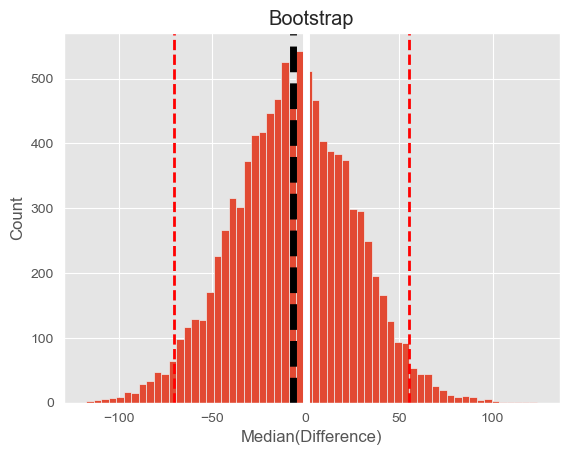

(0.8357343146151623,
 -6.680518223673802,
 [-70.55730972036588, 55.03622291601267])

In [6]:
p_value, bootstrap_difference_mean,\
    bootstrap_confidence_interval, bootstrap_difference_distribution = bootstrap(sample_1, sample_2, statistic=np.median)
p_value, bootstrap_difference_mean, bootstrap_confidence_interval

##### Difference are non-significant($p$_$value$ > 0.05)

In [7]:
p_value

0.8357343146151623

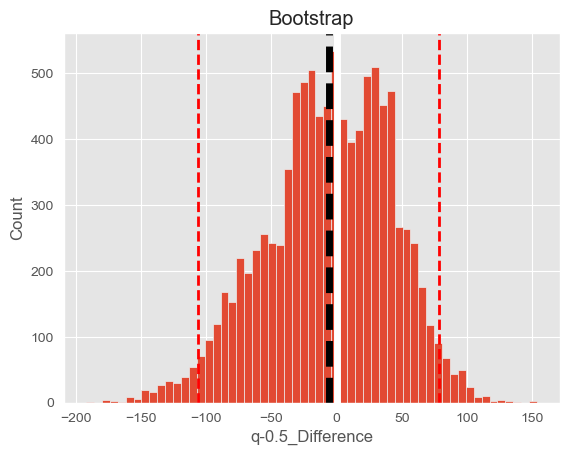

(0.8702320339642178,
 -6.680518223673802,
 [-106.62503904084929, 78.24828192740738])

In [8]:
p_value, bootstrap_mean,\
    bootstrap_confidence_interval, bootstrap_difference_distribution = spotify_two_sample_bootstrap(sample_1, sample_2)
p_value, bootstrap_difference_mean, bootstrap_confidence_interval

##### Difference are non-significant($p$_$value$ > 0.05)

In [9]:
p_value

0.8702320339642178

### Bootstrap recommendations:

1. To estimate 90% CI, the number of bootstrap iterations should be between 1000-2000 (boot_it=2000)
2. To estimate 95% CI, the number of bootstrap iterations should be greater or equal to 5000 (boot_it=5000)

# Experiment 2

Let's model the A/B test experiment with lift in the test sample

In [10]:
# score in test are 10% greater than ctrl (per record)
# ctrl has 5x the number of records as test

lift = 1.1
test = np.random.binomial(100, p=0.2 * lift, size=1000) * 1.0
ctrl = np.random.binomial(100, p=0.2, size=5000) * 1.0
data_df = pd.concat([pd.Series(test), pd.Series(ctrl)], axis=1).rename(columns={0:'test', 1:'ctrl'})

<Axes: ylabel='Count'>

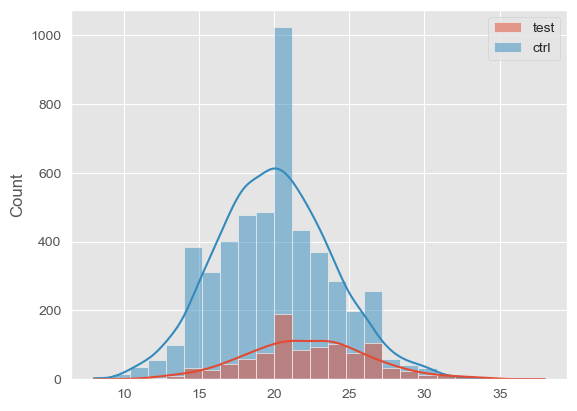

In [11]:
binwidth, bins = estimate_bin_params(test)
sns.histplot(data_df, binwidth=binwidth, bins=bins, kde=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

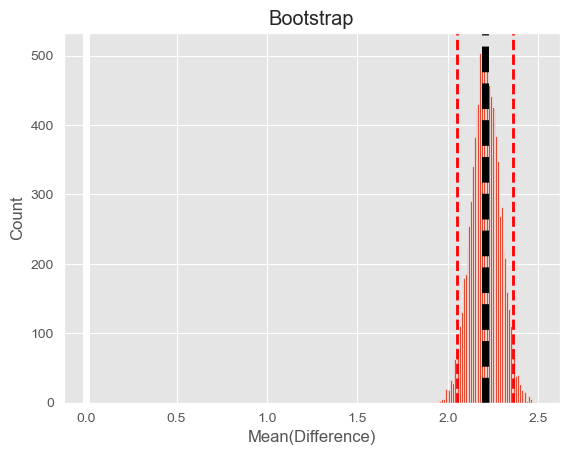

(4.57684205898446e-168, 2.2078065, [2.0494, 2.36221])

In [12]:
p_value, bootstrap_difference_mean, bootstrap_confidence_interval, bootstrap_difference_distribution = bootstrap(ctrl, test)
p_value, bootstrap_difference_mean, bootstrap_confidence_interval

##### Difference are significant($p$_$value$ < 0.05)

In [13]:
p_value

4.57684205898446e-168

# Experiment 3

In [14]:
data_ab = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')

In [15]:
data_ab.head()

,Unnamed: 0,value,experimentVariant
0,1,9.773113,Treatment
1,2,9.311246,Treatment
2,3,11.172828,Treatment
3,4,11.624510,Treatment
4,5,10.462331,Treatment


In [16]:
data_ab.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [17]:
data_ab.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,50


In [18]:
data_ab.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,10.367236


In [19]:
data_ab.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.420193


<Axes: xlabel='experimentVariant', ylabel='value'>

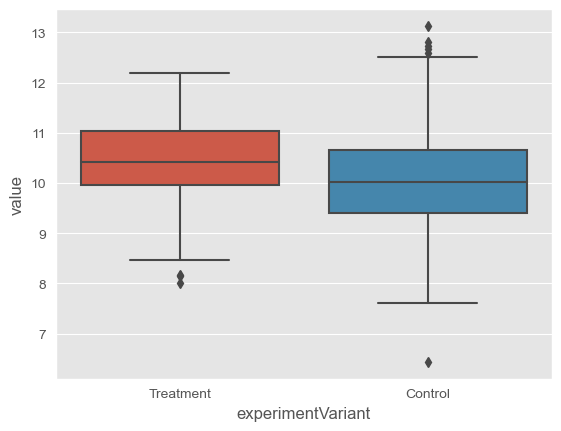

In [20]:
sns.boxplot(x="experimentVariant", y="value", data=data_ab)

<Axes: xlabel='value', ylabel='Count'>

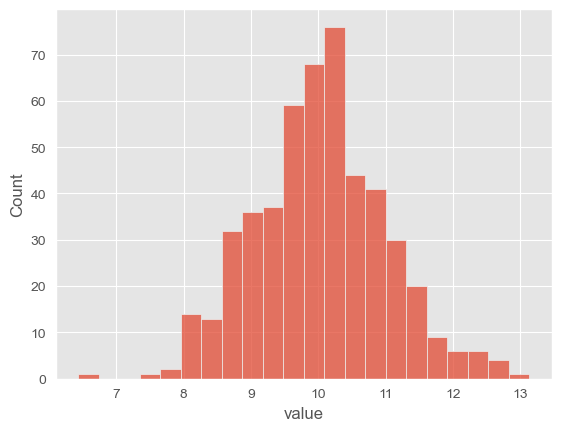

In [21]:
sns.histplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)

<Axes: xlabel='value', ylabel='Count'>

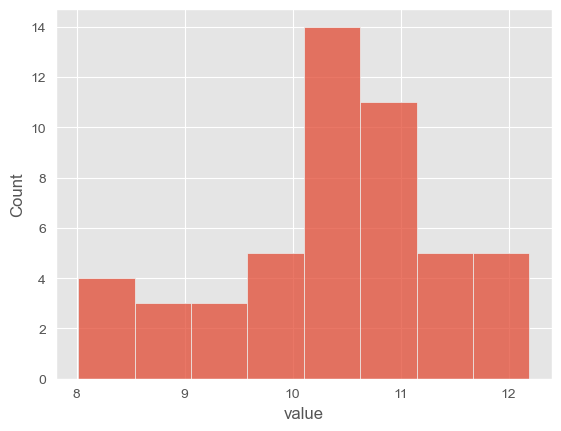

In [22]:
sns.histplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)

In [23]:
mannwhitneyu(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=15492.0, pvalue=0.005236419587596797)

In [24]:
ttest_ind(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.331858965573001, pvalue=0.020069539127355422)

  0%|          | 0/10000 [00:00<?, ?it/s]

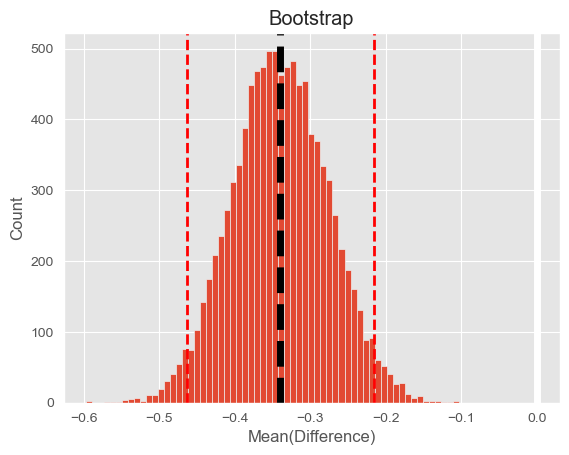

(7.884544855950764e-08,
 -0.33964790142831086,
 [-0.46355395642594366, -0.21537311074383597])

In [25]:
p_value, bootstrap_difference_mean, bootstrap_confidence_interval, bootstrap_difference_distribution = bootstrap(
    data_ab[data_ab.experimentVariant=='Treatment'].value,
    data_ab[data_ab.experimentVariant=='Control'].value,
    statistic=np.mean
)
p_value, bootstrap_difference_mean, bootstrap_confidence_interval

##### Difference are significant($p$_$value$ < 0.05)

In [26]:
p_value

7.884544855950764e-08

  0%|          | 0/10000 [00:00<?, ?it/s]

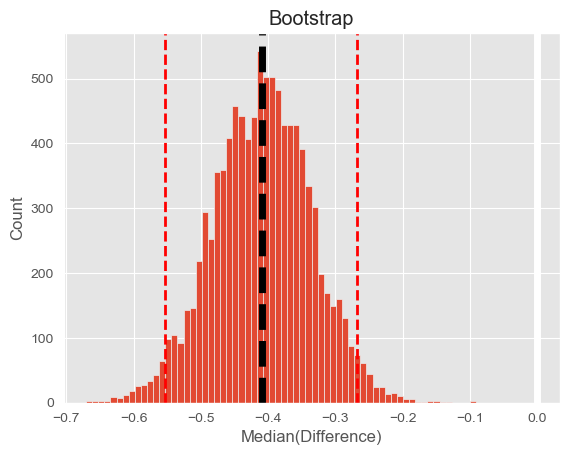

(1.817756456652153e-08,
 -0.4089420712912605,
 [-0.5528069058793404, -0.2673200216551584])

In [27]:
p_value, bootstrap_difference_mean, bootstrap_confidence_interval, bootstrap_difference_distribution = bootstrap(
    data_ab[data_ab.experimentVariant=='Treatment'].value,
    data_ab[data_ab.experimentVariant=='Control'].value,
    statistic=np.median,
)
p_value, bootstrap_difference_mean, bootstrap_confidence_interval

##### Difference are significant($p$_$value$ < 0.05)

In [28]:
p_value

1.817756456652153e-08

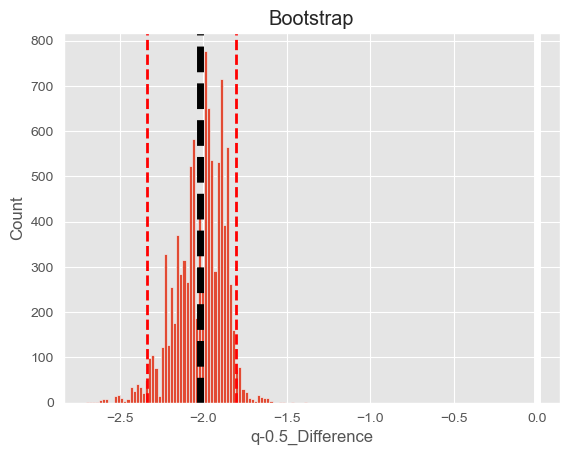

(0.006125637086715333,
 -0.4017279798405511,
 [-2.338892091063311, -1.8046809308780603])

In [29]:
p_value, bootstrap_difference_mean, bootstrap_confidence_interval, bootstrap_difference_distribution = \
    spotify_two_sample_bootstrap(
        data_ab[data_ab.experimentVariant=='Treatment'].value,
        data_ab[data_ab.experimentVariant=='Control'].value,
    )
p_value, bootstrap_difference_mean, bootstrap_confidence_interval

# Experiment 4

In [30]:
ctr_data = pd.read_csv('ctr_data.csv')

In [31]:
ctr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   impression_id    237609 non-null  object
 1   impression_time  237609 non-null  object
 2   user_id          237609 non-null  int64 
 3   app_code         237609 non-null  int64 
 4   os_version       237609 non-null  object
 5   is_4G            237609 non-null  int64 
 6   is_click         237609 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 12.7+ MB


In [32]:
ctr_data.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [33]:
user_level_ctr = ctr_data.groupby('user_id', as_index=False).agg({'is_click': ['sum', 'count']})
user_level_ctr.columns = ['user_id', 'clicks', 'views']
user_level_ctr.head()

,user_id,clicks,views
0,0,0,1
1,2,0,4
2,3,0,1
3,5,0,2
4,6,0,1


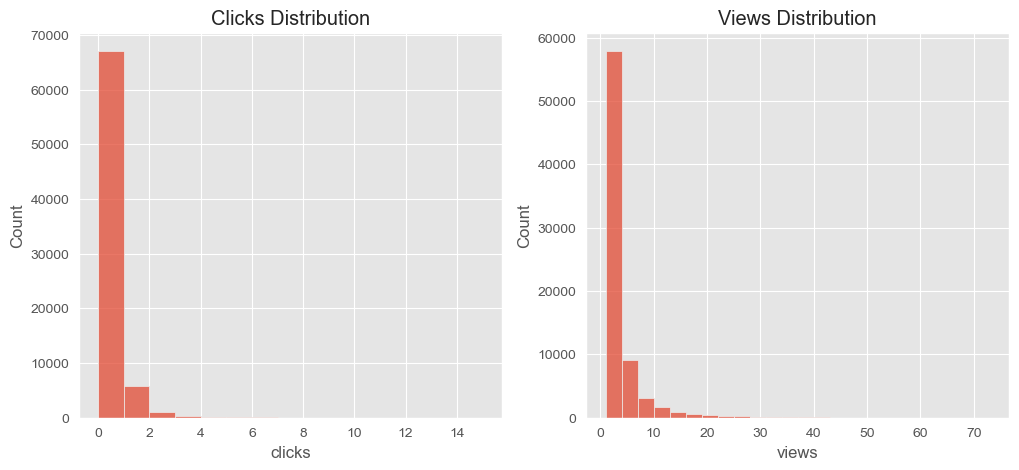

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].set_title('Clicks Distribution')
sns.histplot(ax=axes[0], data=user_level_ctr['clicks'], binwidth=1)
axes[1].set_title('Views Distribution')
sns.histplot(ax=axes[1], data=user_level_ctr['views'], binwidth=3)
plt.show()

In [35]:
control_group_data = user_level_ctr.sample(n=user_level_ctr.shape[0] // 2, random_state=33)
treatment_group_data = user_level_ctr.iloc[user_level_ctr.user_id.isin(~control_group_data.user_id).index]
control_group_data['group_label'] = 'control'
treatment_group_data['group_label'] = 'treatment'

In [36]:
user_level_ctr = pd.concat([control_group_data, treatment_group_data]).sort_values('user_id')
user_level_ctr.head()

,user_id,clicks,views,group_label
0,0,0,1,control
0,0,0,1,treatment
1,2,0,4,treatment
2,3,0,1,treatment
2,3,0,1,control


In [37]:
contingency_table = user_level_ctr.copy()
contingency_table['views'] = contingency_table['views'] - contingency_table['clicks']
contingency_table.rename(columns={'clicks': 'click', 'views': 'no_click'}, inplace=True)
contingency_table = pd.melt(contingency_table, id_vars=['user_id', 'group_label'], value_vars=['click', 'no_click'], var_name='is_click', value_name='count')
contingency_table = contingency_table.pivot_table(index='is_click', columns='group_label', values='count', aggfunc='sum')
contingency_table.columns.name, contingency_table.index.name = '', ''
contingency_table

,control,treatment
,,
click,5289,10862
no_click,111981,226747


In [38]:
global_ctr_control = control_group_data['clicks'].sum() / control_group_data['views'].sum()
global_ctr_treatment = treatment_group_data['clicks'].sum() / treatment_group_data['views'].sum()

In [39]:
print('Control group global CTR: {:.2%}'.format(global_ctr_control))
print('Treatment group global CTR: {:.2%}'.format(global_ctr_treatment))

Control group global CTR: 4.51%
Treatment group global CTR: 4.57%


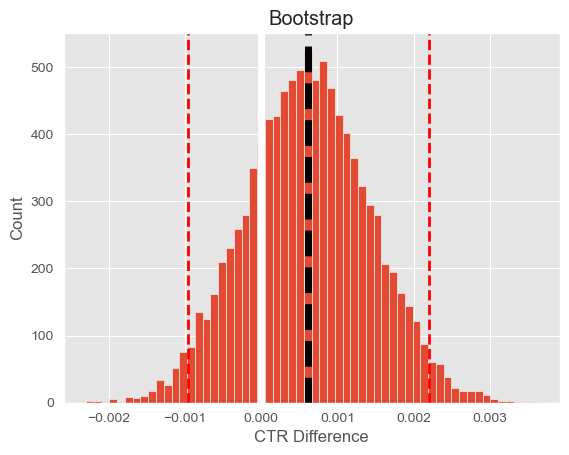

(0.4523314260330469,
 0.000610624188249569,
 [-0.0009576431201593383, 0.0022015080458803577])

In [40]:
p_value, bootstrap_difference_mean, \
    bootstrap_confidence_interval, bootstrap_difference_distribution  = ctr_bootstrap(control_group_data, treatment_group_data)
p_value, bootstrap_difference_mean, bootstrap_confidence_interval

##### Difference are non-significant($p$_$value$ > 0.05)

In [41]:
p_value

0.4523314260330469